## Tests


In [2]:
import torch


### Mean and variance of quantiles to calculate costs like GP-MPC



In [ ]:
def estimate_mean_variance_batch_torch(quantiles: torch.Tensor):
    """
    Estimate mean and variance for each row of a batch of quantiles using PyTorch.
    
    Parameters:
        quantiles (torch.Tensor): shape (N, Q), where Q = 11 for deciles

    Returns:
        mean: Tensor of shape (N,)
        var: Tensor of shape (N,)
    """
    N, Q = quantiles.shape
    assert Q == 11, "Expected 11 quantiles per row for deciles (0%, 10%, ..., 100%)"

    q_left = quantiles[:, :-1]    # shape (N, 10)
    q_right = quantiles[:, 1:]    # shape (N, 10)
    delta_q = q_right - q_left

    # Avoid division by zero: set density = 0 where delta_q == 0
    density = torch.where(delta_q != 0, 0.1 / delta_q, torch.zeros_like(delta_q))

    # First moment (mean): E[X] = ∑ f_i * (q_i^2 - q_{i-1}^2)/2
    mean_terms = density * (q_right**2 - q_left**2) / 2
    print("mean_terms shape:", mean_terms.shape)  # Debugging line
    mean = mean_terms.sum(dim=1)

    # Second moment: E[X²] = ∑ f_i * (q_i^3 - q_{i-1}^3)/3
    moment2_terms = density * (q_right**3 - q_left**3) / 3
    print("moment2_terms shape:", moment2_terms.shape)  # Debugging line
    moment2 = moment2_terms.sum(dim=1)

    var = moment2 - mean**2
    return mean, var



In [37]:
quantile_tensor = torch.tensor([
    [1.0, 1.1, 1.3, 1.6, 2.0, 2.5, 3.1, 3.8, 4.6, 5.5, 6.5],
    [0.5, 0.7, 1.0, 1.5, 2.1, 2.8, 3.6, 4.5, 5.5, 6.6, 7.8],
    [2.0, 2.2, 2.3, 2.4, 2.5, 2.7, 2.9, 3.2, 3.6, 4.1, 4.7]
], dtype=torch.float32)

means, variances = estimate_mean_variance_batch_torch(quantile_tensor)
print("Means:", means)
print("Variances:", variances)


mean_terms shape: torch.Size([3, 10])
moment2_terms shape: torch.Size([3, 10])
Means: tensor([2.9250, 3.2450, 2.9250])
Variances: tensor([2.6597, 4.7200, 0.5170])


### New sampling to find next state using predicted quantiles



Numpy version


In [43]:
import numpy as np

# Assume q_values is a numpy array containing the quantiles q_i
# For example:
# q_values = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])

def predict_next_state(q_values, N_samples, nb_quantiles, state_dim): # s_t, a_t, 
    # Initialize an array to store predicted next states
    predicted_states = []
    
    # Iterate over the number of samples
    for j in range(N_samples):
        # Initialize an array to store next state predictions for each particle
        next_state_predictions = []
        
        # Iterate over each particle
        
        # predicted_states = torch.zeros(nb_quantiles, state_dim)
        
        # Iterate over each state componentd
        for k in range(state_dim): # len(s_t)
            
        # for k in range(state_dim):
            # Randomly choose i from U(0, 10) for each state component
            i = np.random.uniform(0, 10)
            # i = torch.randint(low=0, high=10, size=(1,))
            
            # Compute floor(i) and ceil(i)
            floor_i = int(np.floor(i))
            ceil_i = int(np.ceil(i)) # equivalent to floor_i + 1
            
            # Get next state prediction using the formula provided
            s_next_j = (1 - i + floor_i) * q_values[:, floor_i, k] + (i - floor_i) * q_values[:, ceil_i, k]
            
            # Append the prediction to next state predictions for the current particle
            next_state_predictions.append(s_next_j)
            
            # predicted_states[j ,k] = s_next_j
        
        # Save next state predictions for current sample
        predicted_states.append(next_state_predictions)
    
    
    return predicted_states

# # Example usage
# s_t = [0.5, 0.7]  # Example current state
# a_t = 1  # Example chosen action
# N_samples = 3  # Number of samples

# # Call the function to predict next states
# predicted_states = predict_next_state(s_t, a_t, N_samples)

# # Output the predicted states
# print("Predicted States:")
# for j, states in enumerate(predicted_states):
#     print(f"Sample {j+1}: {states}")

# Calculate costs and find the state associated with the smallest cost (not fully implemented in this snippet)


In [44]:
num_particles = 1
state_dim = 3
nb_quantiles = 11
N_samples = 5
q_values = torch.randn((1, nb_quantiles, state_dim))  # Example quantile tensor

print("q_values ", q_values, "\n")

predicted_states = predict_next_state(q_values, N_samples, nb_quantiles, state_dim)
#predict_next_state(s_t, a_t, N_samples)

# Output the predicted states
print("Predicted States:")
for j, states in enumerate(predicted_states):
    print(f"Sample {j+1}: {states}")


q_values  tensor([[[-1.3367, -1.0672, -0.6077],
         [ 0.5192, -0.0749,  0.9591],
         [-0.4950, -0.2104, -0.0719],
         [ 0.2416,  0.4533,  1.8412],
         [ 0.3348, -0.1472, -1.2693],
         [ 1.0866,  0.8797, -0.7862],
         [-0.1229, -0.3895,  0.9452],
         [-1.3153,  0.0777, -0.1026],
         [ 0.7231,  1.4819, -2.4819],
         [-0.0367,  2.0877,  0.2029],
         [-0.7279,  0.3578, -0.1322]]]) 

Predicted States:
Sample 1: [tensor([0.1829]), tensor([1.3081]), tensor([1.7681])]
Sample 2: [tensor([-0.2567]), tensor([1.4688]), tensor([0.1332])]
Sample 3: [tensor([0.1808]), tensor([1.6165]), tensor([-1.1817])]
Sample 4: [tensor([0.3270]), tensor([0.8868]), tensor([0.9143])]
Sample 5: [tensor([0.2671]), tensor([1.5230]), tensor([0.5046])]


Tensor version


In [ ]:
import numpy as np

# Assume q_values is a numpy array containing the quantiles q_i
# For example:
# q_values = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])

def predict_next_state(q_values, N_samples, nb_quantiles, state_dim): # s_t, a_t, 
    # Initialize an array to store predicted next states
    predicted_states = []
    
    # Iterate over the number of samples
    for j in range(N_samples):
        # Initialize an array to store next state predictions for each particle
        next_state_predictions = []
        
        # Iterate over each particle
        
        # predicted_states = torch.zeros(nb_quantiles, state_dim)
        
        # Iterate over each state componentd
        for k in range(state_dim): # len(s_t)
            
        # for k in range(state_dim):
            # Randomly choose i from U(0, 10) for each state component
            i = np.random.uniform(0, 10)
            # i = torch.randint(low=0, high=10, size=(1,))
            
            # Compute floor(i) and ceil(i)
            floor_i = int(np.floor(i))
            ceil_i = int(np.ceil(i)) # equivalent to floor_i + 1
            
            # Get next state prediction using the formula provided
            s_next_j = (1 - i + floor_i) * q_values[:, floor_i, k] + (i - floor_i) * q_values[:, ceil_i, k]
            
            # Append the prediction to next state predictions for the current particle
            next_state_predictions.append(s_next_j)
            
            # predicted_states[j ,k] = s_next_j
        
        # Save next state predictions for current sample
        predicted_states.append(next_state_predictions)
    
    
    return predicted_states

# # Example usage
# s_t = [0.5, 0.7]  # Example current state
# a_t = 1  # Example chosen action
# N_samples = 3  # Number of samples

# # Call the function to predict next states
# predicted_states = predict_next_state(s_t, a_t, N_samples)

# # Output the predicted states
# print("Predicted States:")
# for j, states in enumerate(predicted_states):
#     print(f"Sample {j+1}: {states}")

# Calculate costs and find the state associated with the smallest cost (not fully implemented in this snippet)


In [ ]:
num_particles = 1
state_dim = 3
nb_quantiles = 11
N_samples = 5
q_values = torch.randn((1, nb_quantiles, state_dim))  # Example quantile tensor

print("q_values ", q_values, "\n")

predicted_states = predict_next_state(q_values, N_samples, nb_quantiles, state_dim)
#predict_next_state(s_t, a_t, N_samples)

# Output the predicted states
print("Predicted States:")
for j, states in enumerate(predicted_states):
    print(f"Sample {j+1}: {states}")


In [35]:
torch.randint(low=0, high=10, size=(num_particles,state_dim))



tensor([[9, 3, 4]])

In [25]:
# chosen_quantiles = np.random.uniform(0, 1, (num_particles, state_dim))
chosen_quantiles = torch.rand(num_particles, state_dim)
# https://pytorch.org/docs/main/generated/torch.rand.html
bottom_int_indices = torch.floor(chosen_quantiles*10).to(torch.int) # .astype(int)
top_int_indices = bottom_int_indices+1
top_int_indices[top_int_indices == 11] = 10

# Expand batch dimension to match indexing (assuming batch_size = 1)
batch_indices = torch.zeros((num_particles, state_dim), dtype=torch.long)  # Shape (num_particles, state_dim)

# pred_bottom_quantiles = predicted_quantiles[:, bottom_int_indices, :]
# pred_top_quantiles = predicted_quantiles[:, top_int_indices, :]
pred_bottom_quantiles = q_values[batch_indices, bottom_int_indices, torch.arange(state_dim)]
pred_top_quantiles = q_values[batch_indices, top_int_indices, torch.arange(state_dim)]

print("quantiles:", q_values)
print("pred_bottom_quantiles:", pred_bottom_quantiles)
print("pred_top_quantiles:", pred_top_quantiles)
           

quantiles: tensor([[[-0.6995, -0.2478, -1.0221],
         [ 1.1351,  2.2560, -0.6527],
         [-1.1693, -0.3257, -2.3287],
         [ 1.4955, -1.2222, -0.0411],
         [-0.7777, -0.6744,  1.3442],
         [-1.8938,  1.1230, -1.1988],
         [ 0.4336,  0.3880,  0.1117],
         [-0.7841,  0.9974, -0.0526],
         [ 0.9826, -0.0603,  0.2936],
         [-0.1171, -0.3358, -0.6085],
         [-1.0649,  0.0310,  1.0077]]])
pred_bottom_quantiles: tensor([[-1.8938, -0.3257, -1.0221]])
pred_top_quantiles: tensor([[ 0.4336, -1.2222, -0.6527]])


## Good graph


c:\Users\nicle\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


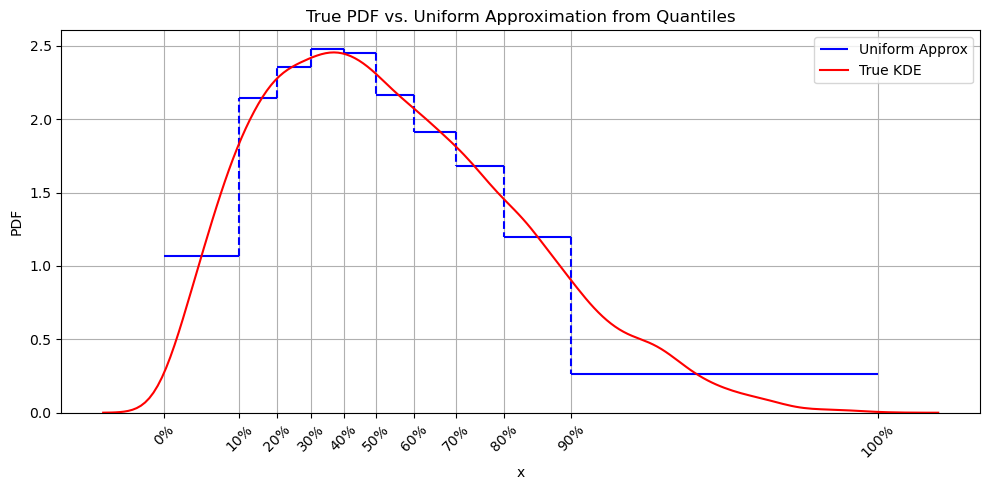

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate data from a known distribution (e.g., Beta, Normal)
np.random.seed(0)
data = np.random.beta(a=2, b=5, size=10000)

# Calculate decile quantiles
quantiles = np.percentile(data, np.arange(0, 110, 10))
percentiles = [f"{i*10}%" for i in range(len(quantiles))]

# Uniform PDF approximation
pdf_heights = 0.1 / (quantiles[1:] - quantiles[:-1])

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 5))

# Uniform approximation (step PDF)
for i in range(len(pdf_heights)):
    ax.hlines(pdf_heights[i], quantiles[i], quantiles[i+1], colors='blue', label='Uniform Approx' if i == 0 else "")
    if i < len(pdf_heights) - 1:
        ax.vlines(quantiles[i+1], pdf_heights[i], pdf_heights[i+1], colors='blue', linestyle='--')

# KDE (true smooth estimate)
sns.kdeplot(data, color='red', label='True KDE', ax=ax)

# Tick labels
ax.set_xticks(quantiles)
ax.set_xticklabels(percentiles, rotation=45)

ax.set_xlabel('x')
ax.set_ylabel('PDF')
ax.set_title('True PDF vs. Uniform Approximation from Quantiles')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Other test graphs



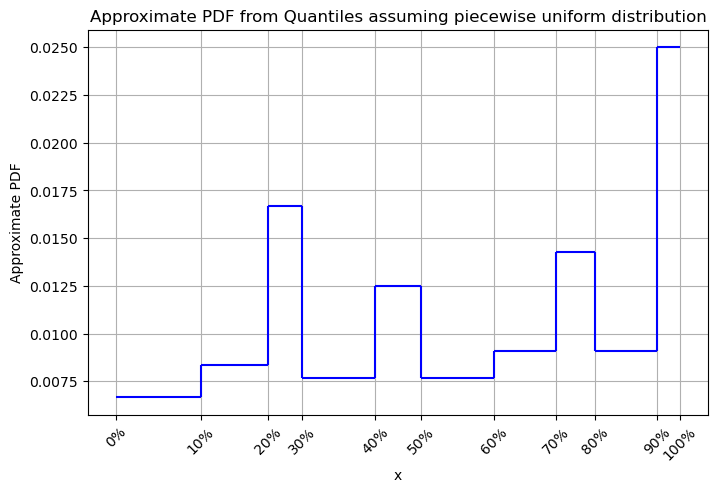

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example quantiles from 0% to 100% (replace with your actual quantiles)
quantiles = np.array([0, 15, 27, 33, 46, 54, 67, 78, 85, 96, 100])
percentiles = [f"{i*10}%" for i in range(len(quantiles))]

# Probabilities for each quantile (0, 0.1, ..., 1.0)
probs = np.linspace(0, 1, len(quantiles))

# Calculate PDF heights for each interval
pdf_heights = 0.1 / (quantiles[1:] - quantiles[:-1])  # 0.1 = width of each probability interval

# Plot the piecewise uniform PDF as a step function
fig, ax = plt.subplots(figsize=(8, 5))

for i in range(len(pdf_heights)):
    # Plot a horizontal line (PDF) over each interval
    ax.hlines(pdf_heights[i], quantiles[i], quantiles[i+1], colors='blue')
    # Also plot vertical lines to connect steps for clarity
    if i < len(pdf_heights) - 1:
        ax.vlines(quantiles[i+1], pdf_heights[i], pdf_heights[i+1], colors='blue')

ax.set_xlabel('x')
ax.set_xticks(quantiles)  # Set tick positions at quantile values
ax.set_xticklabels(percentiles, rotation=45)  # Set corresponding percentile labels
ax.set_ylabel('Approximate PDF')
ax.set_title('Approximate PDF from Quantiles assuming piecewise uniform distribution')
plt.grid(True)
plt.show()


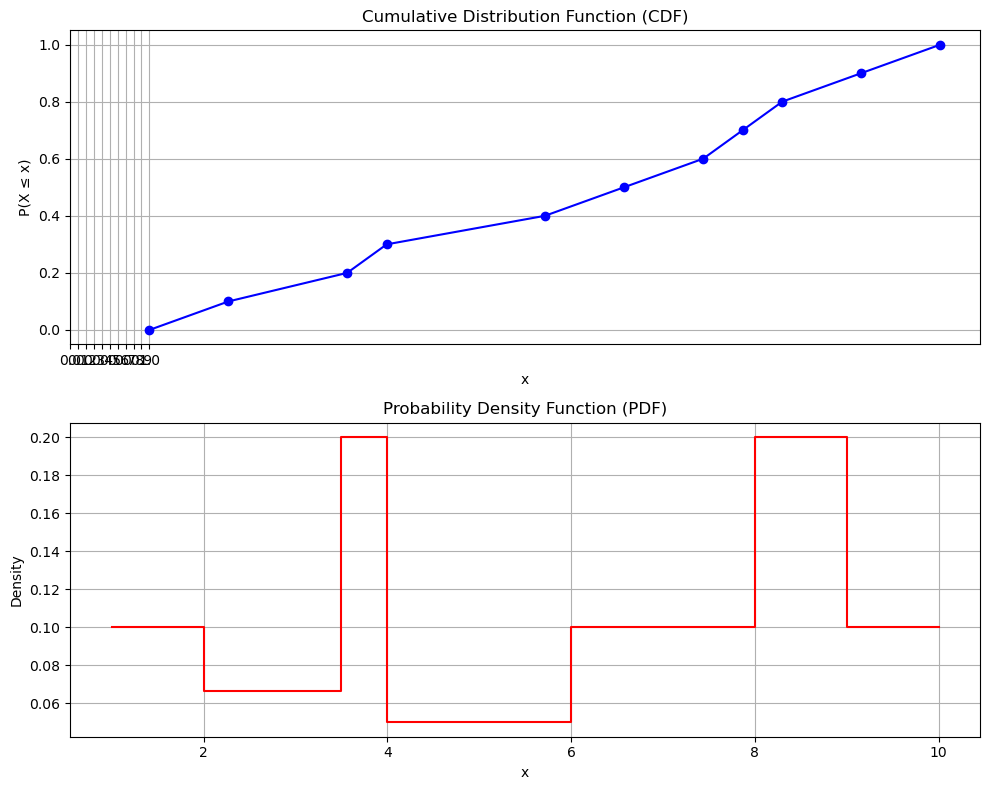

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your quantile data (replace with actual values)
quantiles = {
    0.0: 1.0,   # p=0.0, x=1.0
    0.1: 2.0,   # p=0.1, x=2.0
    0.2: 3.5,   # Note: Uneven spacing (x jumps by 1.5)
    0.3: 4.0,
    0.4: 6.0,
    0.5: 7.0,
    0.6: 8.0,
    0.7: 8.5,
    0.8: 9.0,
    0.9: 10.0,
    1.0: 11.0
}

# Extract percentiles (p) and quantile values (x_p)
p = np.array(sorted(quantiles.keys()))
x_p = np.array([quantiles[pi] for pi in p])

# Compute PDF: slope between adjacent quantiles
pdf_values = np.diff(p) / np.diff(x_p)  # (Δp/Δx)
x_pdf = x_p[:-1]  # PDF starts at x_i (left edges)

# Plot CDF and PDF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# 1. Plot CDF (piecewise linear)
ax1.plot(x_p, p, 'b-', marker='o', label='CDF (linear interpolation)')
ax1.set_title('Cumulative Distribution Function (CDF)')
ax1.set_xlabel('x')
ax1.set_ylabel('P(X ≤ x)')
# ax1.set_xticks(p)  # Set x-ticks to match quantile values
ax1.grid(True)

# 2. Plot PDF (piecewise constant)
ax2.step(x_pdf, pdf_values, 'r-', where='post', label='PDF (uniform segments)')
ax2.set_title('Probability Density Function (PDF)')
ax2.set_xlabel('x')
ax2.set_ylabel('Density')
ax2.grid(True)

plt.tight_layout()
plt.show()